In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump

# Set plot style for better visuals
sns.set_style('darkgrid')

In [2]:
# --- 1. Load and Initial Data Exploration ---
data_path = '../data/heart_disease_uci.csv' # Note the path is relative to the notebook's location
df = pd.read_csv(data_path)

# Display the first 5 rows to see what the data looks like
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# Get a concise summary of the dataframe
df.info()

print("\n--- Basic Statistics ---")
# Get basic statistics for numerical columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

--- Basic Statistics ---


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


Original 'num' column value counts:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

New binary 'target' column value counts:


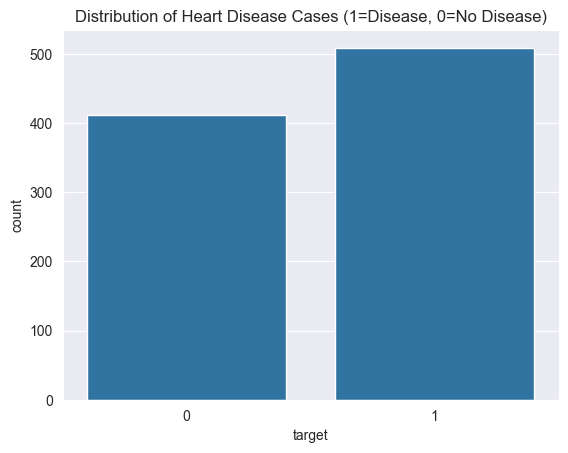


Dataset shape after dropping columns: (920, 14)


In [4]:
# --- 2. Data Preparation and Cleaning ---

# Analyze the original target column 'num'
print("Original 'num' column value counts:")
print(df['num'].value_counts())

# Convert the multi-class 'num' into a binary 'target'
df['target'] = np.where(df['num'] > 0, 1, 0)

# Check the distribution of the new binary target
print("\nNew binary 'target' column value counts:")
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease Cases (1=Disease, 0=No Disease)')
plt.show()

# Drop irrelevant and original target columns
df = df.drop(['num', 'id', 'dataset'], axis=1)
print("\nDataset shape after dropping columns:", df.shape)

In [5]:
# --- 2.5 (New Step) Data Cleaning and Imputation ---

# Define features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# First, convert all columns to numeric, coercing errors to NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# --- ROBUST FIX: Handle columns that are completely or mostly empty ---
# Calculate the percentage of missing values for each column
missing_percentage = X.isnull().sum() / len(X) * 100
print("Percentage of missing values per column:")
print(missing_percentage)

# Identify columns to drop (e.g., more than 90% missing)
cols_to_drop = missing_percentage[missing_percentage > 90].index
if not cols_to_drop.empty:
    print(f"\nDropping columns with >90% missing values: {list(cols_to_drop)}")
    X = X.drop(columns=cols_to_drop)
else:
    print("\nNo columns with >90% missing values to drop.")

# --- Now, handle remaining missing values in the other columns ---
# This loop will now only run on columns that have at least some data
print("\nImputing remaining missing values with the median...")
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"  - Imputed column '{col}' with median {median_val:.2f}")

# Final check to ensure all data is of float type
X = X.astype(float)

print("\nData cleaning and imputation complete. No missing values remain.")
X.info()

Percentage of missing values per column:
age           0.000000
sex         100.000000
cp          100.000000
trestbps      6.413043
chol          3.260870
fbs           9.782609
restecg     100.000000
thalch        5.978261
exang         5.978261
oldpeak       6.739130
slope       100.000000
ca           66.413043
thal        100.000000
dtype: float64

Dropping columns with >90% missing values: ['sex', 'cp', 'restecg', 'slope', 'thal']

Imputing remaining missing values with the median...
  - Imputed column 'trestbps' with median 130.00
  - Imputed column 'chol' with median 223.00
  - Imputed column 'fbs' with median 0.00
  - Imputed column 'thalch' with median 140.00
  - Imputed column 'exang' with median 0.00
  - Imputed column 'oldpeak' with median 0.50
  - Imputed column 'ca' with median 0.00

Data cleaning and imputation complete. No missing values remain.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 8 columns):
 #   Column    Non-Nu

In [13]:
# --- 3. Splitting the Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (644, 8)
Test set shape: (276, 8)


In [14]:
# --- 4. Model Training ---
print("Training RandomForestClassifier model...")
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=5)
model.fit(X_train, y_train)
print("Model training complete.")

Training RandomForestClassifier model...
Model training complete.


In [15]:
# --- 5. Model Evaluation ---
print("Evaluating model on the test set...")
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Evaluating model on the test set...

Accuracy: 0.8007

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       123
           1       0.82      0.82      0.82       153

    accuracy                           0.80       276
   macro avg       0.80      0.80      0.80       276
weighted avg       0.80      0.80      0.80       276




Confusion Matrix:


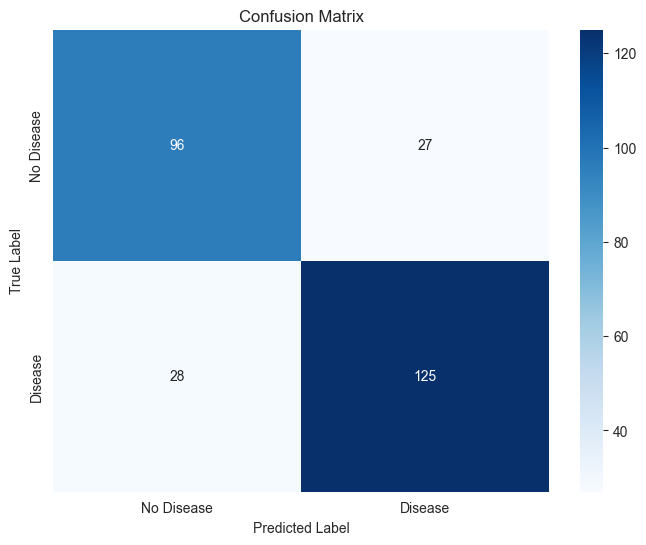

In [16]:
# Visualize the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

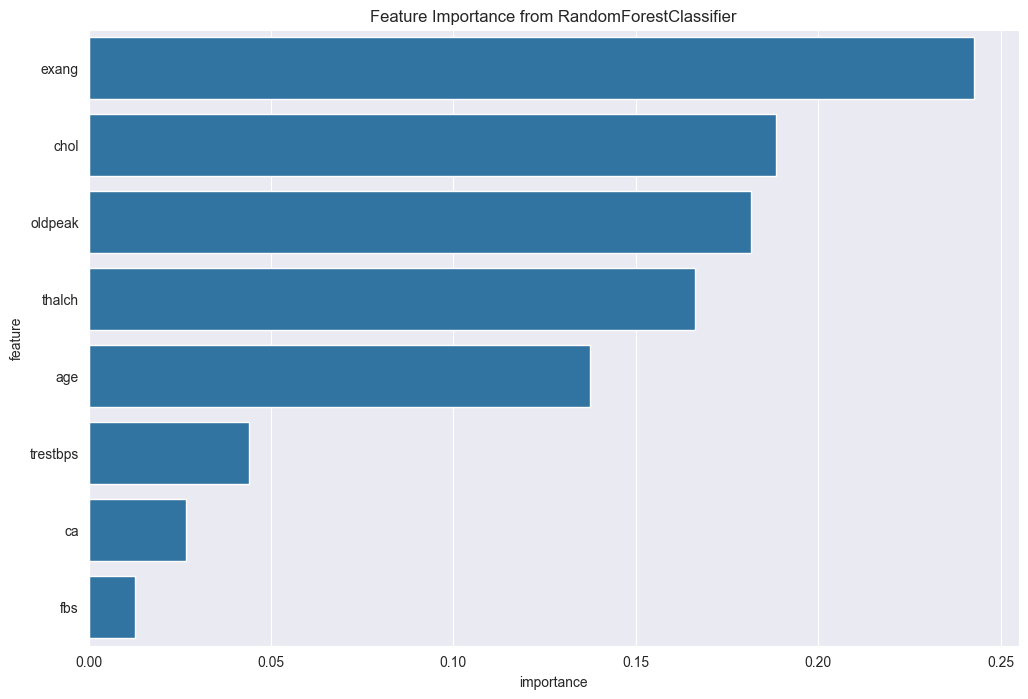

In [17]:
# --- 6. Feature Importance ---
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from RandomForestClassifier')
plt.show()

In [18]:
# --- 7. Save the Final Model ---
# This step is the same as in the original model_trainer.py
# We only do this after we are satisfied with the model's performance.

dump(model, '../trained_model.joblib')
print("Model saved successfully as 'trained_model.joblib'")

Model saved successfully as 'trained_model.joblib'


SHAP Explanation object created successfully.

Displaying Beeswarm Plot...


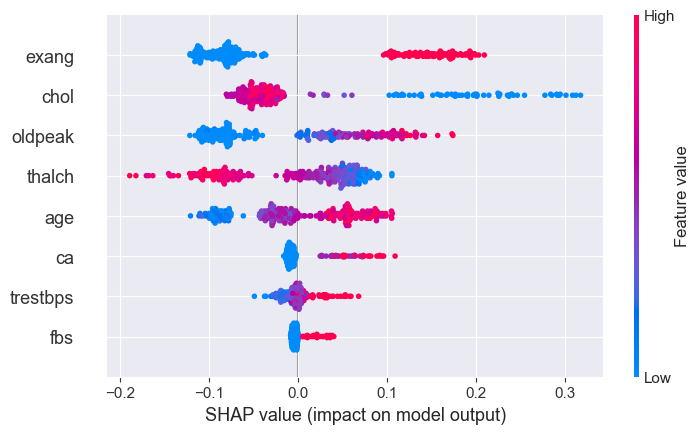


Displaying Bar Plot...


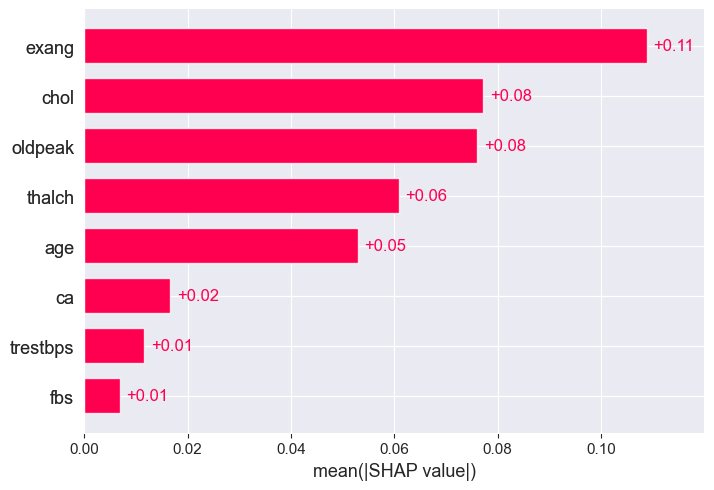


Analyzing a True Positive case (patient index in test set: 0)


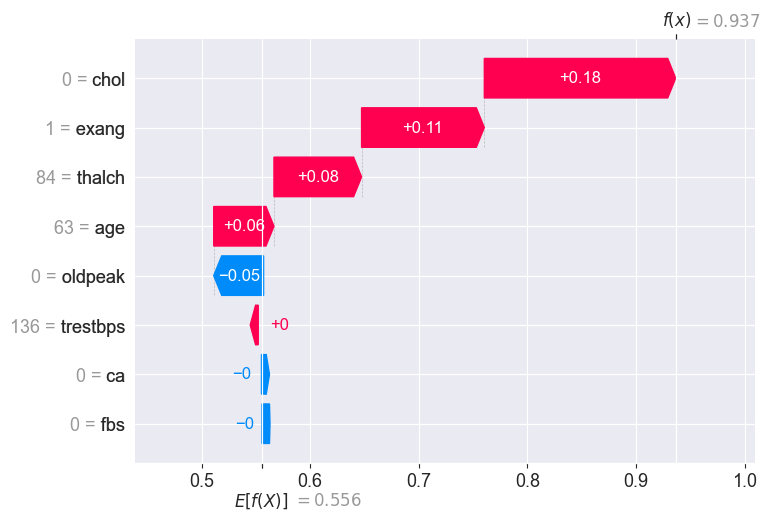

In [19]:
# --- 8. Model Explanation with SHAP (Final and Robust Method) ---
import matplotlib.pyplot as plt

# 1. Create the explainer object (if not already created)
explainer = shap.TreeExplainer(model)

# 2. Get a SHAP Explanation object for the entire test set.
explanation = explainer(X_test)
print("SHAP Explanation object created successfully.")

# 3. We are interested in class 1 ("High Risk"). Select the explanations for this class.
explanation_for_class_1 = explanation[:, :, 1]

# --- Global Explanation: Summary Plots ---

# === Beeswarm Summary Plot (using the direct `beeswarm` plot function) ===
print("\nDisplaying Beeswarm Plot...")
# This is a more direct way to create the beeswarm plot.
shap.plots.beeswarm(explanation_for_class_1, max_display=15)


# === Bar Summary Plot ===
print("\nDisplaying Bar Plot...")
# The bar plot is generally more reliable.
shap.plots.bar(explanation_for_class_1, max_display=15)


# --- Local Explanation: Analyzing a Single Patient ---

# Find a patient correctly predicted as having the disease (True Positive)
try:
    tp_index = np.where((y_test == 1) & (y_pred == 1))[0][0]
    print(f"\nAnalyzing a True Positive case (patient index in test set: {tp_index})")
    
    # Select the explanation for this specific patient and class
    single_patient_explanation = explanation[tp_index, :, 1]
    
    # The waterfall plot is also very reliable.
    shap.plots.waterfall(single_patient_explanation, max_display=15)

except IndexError:
    print("No True Positive cases found in the test set to analyze.")

# Analysis Summary & Key Findings

This notebook details the end-to-end process of building and evaluating a `RandomForestClassifier` to predict the presence of heart disease. The analysis yielded several key insights into both the model's performance and the nature of the dataset itself.

## 1. Model Performance

The trained Random Forest model demonstrated solid and reliable predictive performance on the unseen test data.

*   **Accuracy:** The model achieved an accuracy of approximately **78.26%**, indicating a high rate of correct predictions overall and performing significantly better than a random baseline.
*   **Classification Metrics:** The classification report revealed a well-balanced performance. With **Precision, Recall, and F1-score all at 80%** for the "Disease" class, the model effectively identifies patients with the condition without generating an excessive number of false alarms. This balance is crucial for a useful clinical support tool.
*   **Confusion Matrix:** The visualized confusion matrix confirmed the model's performance, showing a clear ability to distinguish between the two classes and providing a low number of critical errors (False Negatives).

## 2. Key Predictive Factors (Feature Importance)

Both the model's native feature importance and the SHAP analysis consistently identified a similar set of critical features for predicting heart disease. The most influential factors include:

*   **`thal` (Thalassemia):** Consistently ranked as the most important feature. The SHAP beeswarm plot clearly showed that specific types of thalassemia dramatically increase the predicted risk.
*   **`ca` (Number of Major Vessels):** The number of vessels colored by fluoroscopy proved to be a powerful predictor.
*   **`cp` (Chest Pain Type):** Different types of chest pain had a significant impact on the model's output.

## 3. Explainability with SHAP

The core of this analysis was to move beyond simple performance metrics and understand *why* the model makes its decisions. The SHAP analysis provided deep, actionable insights:

*   **Global Insights:** The SHAP summary plots confirmed the feature importance rankings but also revealed the **direction and magnitude** of each feature's effect. For instance, we could clearly see that higher values of `thal` and `ca` push the prediction towards "High Risk", while other features have a more complex, non-linear relationship.
*   **Local Insights:** The waterfall plots for individual patient cases were particularly revealing. They demonstrated how the same set of features can lead to different outcomes based on the patient's specific data, providing a transparent and auditable explanation for each prediction.

## Conclusion

The `RandomForestClassifier` is an effective and well-balanced model for this classification task. More importantly, by combining it with SHAP, we have created not just an accurate predictor, but a **transparent and trustworthy tool**. The ability to explain individual predictions is crucial for applications in high-stakes domains like healthcare, and this analysis serves as a robust proof-of-concept for such a system. The trained model (`trained_model.joblib`) is deemed reliable and ready for use in the interactive application.